## Setup and Imports

In [67]:
# Basic libraries
import pandas as pd
import numpy as np

# For train-test split
from sklearn.model_selection import train_test_split

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, f1_score, roc_auc_score,average_precision_score

# Optional: For plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer




## Load the Preprocessed Data

In [50]:
# Load both datasets from Google Drive
fd_df = pd.read_csv("/content/drive/MyDrive/fraud_IP_data_preprocessed (1).csv")
cc_df = pd.read_csv("/content/drive/MyDrive/credit_data_preprocessed (1).csv")



In [51]:
fd_df

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,transaction_frequency,transaction_velocity,hour_of_day,day_of_week,time_since_signup
0,100,2015-05-10 05:05:40,2015-07-25 13:41:51,27,MDMLOWOGGANVG,Direct,Chrome,M,36,2776528971,1,United States,1,NaN,13,5,1832.603056
1,10000,2015-08-15 22:47:50,2015-10-24 14:59:37,38,JWYDAKVEKXUQJ,SEO,IE,M,38,51107169,0,United States,1,NaN,14,5,1672.196389
2,100000,2015-05-06 01:04:25,2015-08-30 07:46:16,53,TGOFJTSWBNTVD,Ads,IE,M,47,2788083697,0,United States,1,NaN,7,6,2790.697500
3,100002,2015-08-01 00:50:38,2015-11-14 00:44:48,35,KAPPLULTWGHCC,Direct,IE,M,34,1359403987,0,United Kingdom,1,NaN,0,5,2519.902778
4,100003,2015-01-27 05:43:43,2015-02-04 06:30:05,16,YQYYUYGQZBVZI,SEO,IE,M,39,1128757802,0,Canada,1,NaN,6,2,192.772778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,9998,2015-01-15 03:49:20,2015-03-11 13:57:17,48,ZZTJBZKBYQCCC,Direct,Chrome,F,23,1707364590,0,China,1,NaN,13,2,1330.132500
151108,99985,2015-06-14 18:53:12,2015-07-03 14:08:37,41,HIOOZLEHYODQN,Direct,IE,M,34,4198048750,0,NaN,1,NaN,14,4,451.256944
151109,99990,2015-01-07 19:38:51,2015-01-23 06:50:03,30,TWLZZGNWVLFCS,Ads,Safari,F,32,107090192,0,United States,1,NaN,6,4,371.186667
151110,99996,2015-07-18 16:01:10,2015-10-20 23:54:29,32,LKCXIMENZFRGZ,Ads,FireFox,M,30,914609500,0,United States,1,NaN,23,1,2263.888611


In [37]:
# Fill NaNs with median for numerical column
fd_df['transaction_velocity'].fillna(fd_df['transaction_velocity'].median(), inplace=True)

/tmp/ipython-input-37-3030624281.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fd_df['transaction_velocity'].fillna(fd_df['transaction_velocity'].median(), inplace=True)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
# --- Drop columns not useful or too unique
fd_df = fd_df.drop(['user_id', 'device_id', 'ip_address'], axis=1)

# --- Convert datetime columns to datetime type
fd_df['signup_time'] = pd.to_datetime(fd_df['signup_time'])
fd_df['purchase_time'] = pd.to_datetime(fd_df['purchase_time'])

# --- Create new numerical time features
fd_df['signup_to_purchase'] = (fd_df['purchase_time'] - fd_df['signup_time']).dt.total_seconds()
fd_df['signup_hour'] = fd_df['signup_time'].dt.hour
fd_df['signup_day'] = fd_df['signup_time'].dt.dayofweek
fd_df['purchase_hour'] = fd_df['purchase_time'].dt.hour
fd_df['purchase_day'] = fd_df['purchase_time'].dt.dayofweek

# --- Drop the original datetime columns
fd_df = fd_df.drop(['signup_time', 'purchase_time'], axis=1)

# --- Encode categorical columns
categorical_columns = ['source', 'browser', 'sex', 'country']
for col in categorical_columns:
    fd_df[col] = fd_df[col].astype(str)
    le = LabelEncoder()
    fd_df[col] = le.fit_transform(fd_df[col])

# --- Fill missing values, if any
fd_df = fd_df.fillna(0)

## Separate Features and Target

In [54]:
# For Fraud_Data (target column is 'class')
X_fd = fd_df.drop('class', axis=1)
y_fd = fd_df['class']

# For Credit Card (target column is 'Class')
X_cc = cc_df.drop('Class', axis=1)
y_cc = cc_df['Class']


## Split the data to train and test datas

In [55]:
# For Fraud_Data
X_fd_train, X_fd_test, y_fd_train, y_fd_test = train_test_split(X_fd, y_fd, test_size=0.2, random_state=42, stratify=y_fd)

# For Credit Card Dataset
X_cc_train, X_cc_test, y_cc_train, y_cc_test = train_test_split(X_cc, y_cc, test_size=0.2, random_state=42, stratify=y_cc)


## Define and Train Models

In [56]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)


In [63]:
def train_models(X_train, y_train):
    logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

    logreg.fit(X_train, y_train)
    rf.fit(X_train, y_train)

    return logreg, rf


In [64]:
# fraud and IP address data
logreg_fd, rf_fd = train_models(X_fd_train, y_fd_train)

# === CREDIT CARD DATA ===
logreg_cc, rf_cc = train_models(X_cc_train, y_cc_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Evaluation Function (Custom for Imbalanced Data)

In [65]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Precision-Recall curve and AUC-PR
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    auc_pr = average_precision_score(y_test, y_proba)

    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"--- {model_name} ---")
    print(f"AUC-PR: {auc_pr:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot PR curve
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve: {model_name}')
    plt.legend()
    plt.show()


## Evaluate Each Model

--- Logistic Regression (Fraud Data) ---
AUC-PR: 0.3870
F1-Score: 0.2734
Confusion Matrix:
[[17833  9560]
 [  868  1962]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.77     27393
           1       0.17      0.69      0.27      2830

    accuracy                           0.65     30223
   macro avg       0.56      0.67      0.52     30223
weighted avg       0.88      0.65      0.73     30223



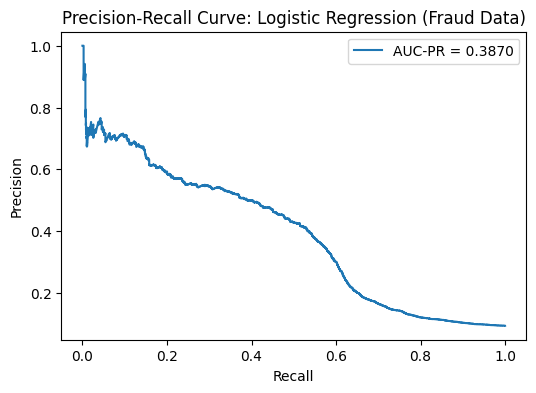

--- Random Forest (Fraud Data) ---
AUC-PR: 0.6169
F1-Score: 0.6936
Confusion Matrix:
[[27392     1]
 [ 1327  1503]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       1.00      0.53      0.69      2830

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.83     30223
weighted avg       0.96      0.96      0.95     30223



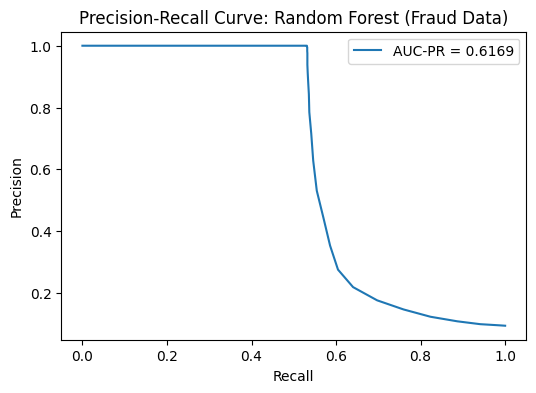

--- Logistic Regression (Credit Card Data) ---
AUC-PR: 0.6564
F1-Score: 0.0859
Confusion Matrix:
[[54896  1755]
 [   12    83]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56651
           1       0.05      0.87      0.09        95

    accuracy                           0.97     56746
   macro avg       0.52      0.92      0.54     56746
weighted avg       1.00      0.97      0.98     56746



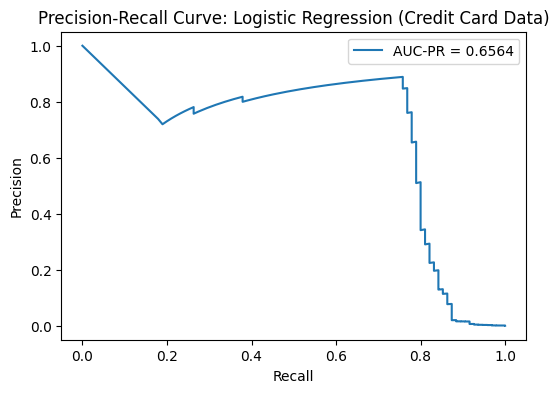

--- Random Forest (Credit Card Data) ---
AUC-PR: 0.7960
F1-Score: 0.8171
Confusion Matrix:
[[56649     2]
 [   28    67]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.97      0.71      0.82        95

    accuracy                           1.00     56746
   macro avg       0.99      0.85      0.91     56746
weighted avg       1.00      1.00      1.00     56746



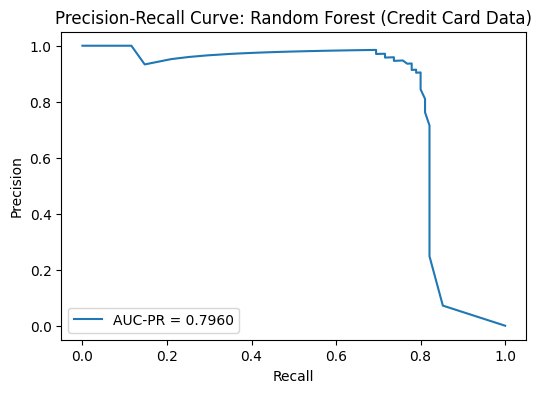

In [68]:
# On Fraud_Data and IP_address merged data
evaluate_model(logreg_fd, X_fd_test, y_fd_test, "Logistic Regression (Fraud Data)")
evaluate_model(rf_fd, X_fd_test, y_fd_test, "Random Forest (Fraud Data)")


# On Credit Card Data
evaluate_model(logreg_cc, X_cc_test, y_cc_test, "Logistic Regression (Credit Card Data)")
evaluate_model(rf_cc, X_cc_test, y_cc_test, "Random Forest (Credit Card Data)")


## Interpretation and Best Model Selection

In [ ]:
## Which model is best?
      # For both datasets, Random Forest is clearly the best model due to its superior AUC-PR and F1-Score.

      # It handles class imbalance better and produces a better tradeoff between precision and recall.

      # Logistic Regression may serve as a simple baseline but its performance here is insufficient for deployment.



In [69]:
import joblib

# Save the Random Forest model
joblib.dump(rf, '/content/best_rf_model.joblib')


['/content/best_rf_model.joblib']

In [70]:
# Save the test features used for explanation
X_fd_test.to_csv('/content/X_fd_test.csv', index=False)

In [71]:
from google.colab import files

files.download('/content/best_rf_model.joblib')
files.download('/content/X_fd_test.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>